<a href="https://colab.research.google.com/github/pati-dev/predict-shopping-intention/blob/master/predict_purchase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boot

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import csv

from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [0]:
path = "/content/drive/My Drive/Personal/IUB/Job apps/Anthem/"

# Load Data

In [0]:
shop = pd.read_csv(path + "online_shoppers_intention.csv")

In [0]:
shop.tail(20)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
12310,1,5.000000,0,0.00,21,411.083333,0.015789,0.016140,0.000000,0.0,Nov,3,2,7,3,Returning_Visitor,False,False
12311,1,0.000000,2,211.25,144,4627.489571,0.001361,0.020664,0.000000,0.0,Nov,2,2,1,2,Returning_Visitor,False,True
12312,7,150.357143,1,9.00,221,11431.001240,0.011149,0.021904,1.582473,0.0,Nov,2,5,1,2,Returning_Visitor,True,True
12313,3,16.000000,3,86.00,15,2773.500000,0.000000,0.030000,78.811725,0.0,Dec,2,2,1,2,Returning_Visitor,False,True
12314,0,0.000000,0,0.00,7,705.833333,0.028571,0.085714,0.000000,0.0,Dec,5,11,4,1,Returning_Visitor,True,False
12315,0,0.000000,0,0.00,7,212.500000,0.000000,0.033333,0.000000,0.0,Nov,3,2,1,11,Returning_Visitor,True,False
12316,0,0.000000,0,0.00,44,615.000000,0.013636,0.036364,0.000000,0.0,Dec,4,1,3,1,Returning_Visitor,False,False
12317,3,100.500000,0,0.00,95,1453.640882,0.002105,0.012761,0.000000,0.0,Dec,2,2,3,2,New_Visitor,False,False
12318,0,0.000000,0,0.00,6,279.000000,0.000000,0.033333,0.000000,0.0,Dec,1,2,3,10,Returning_Visitor,True,False
12319,0,0.000000,0,0.00,21,1128.583333,0.000000,0.013043,3.685401,0.0,Dec,2,2,1,2,Returning_Visitor,False,False


# Data preprocessing

## Feature scaling

In [0]:
print(shop.columns)
print(shop.dtypes)

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object


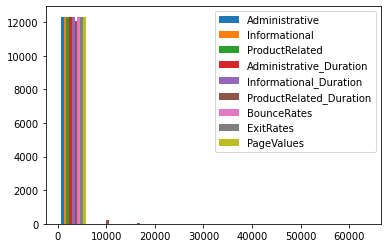

In [3]:
pages = ['Administrative',
         'Informational',
         'ProductRelated',
         'Administrative_Duration',
         'Informational_Duration',
         'ProductRelated_Duration',
         'BounceRates',
         'ExitRates',
         'PageValues']

x_pages = shop.loc[:, pages].values

plt.hist(x_pages, label=pages)
plt.legend()
plt.show()

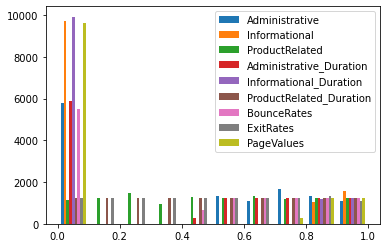

In [4]:
x_pages = QuantileTransformer(output_distribution='uniform').fit_transform(x_pages)
plt.hist(x_pages, label=pages)
plt.legend()
plt.show()

## Dimension reduction

% variance explained: 98.07948987307483


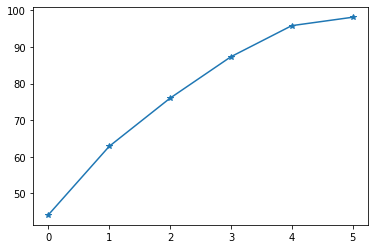

In [5]:
pca = PCA(n_components=6)

pca.fit(x_pages)

print("% variance explained:", sum(pca.explained_variance_ratio_)*100)
variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(variance, marker='*')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """


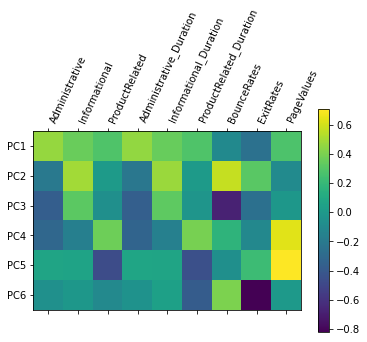

In [6]:
plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0, 1, 2, 3, 4, 5],['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], fontsize=10)
plt.colorbar()
plt.xticks(range(len(pages)),pages,rotation=65,ha='left')
plt.tight_layout()
plt.show()

## Feature manipulation

In [0]:
pages_pca = pca.fit_transform(x_pages)

df_pages_pca = pd.DataFrame(data = pages_pca,
                            columns = ['pages_pc1',
                                       'pages_pc2',
                                       'pages_pc3',
                                       'pages_pc4',
                                       'pages_pc5',
                                       'pages_pc6'])

shop['is_weekend'] = np.where(shop['Weekend']==True, 1, 0)
shop['returning_visitor'] = np.where(shop['VisitorType']=="Returning_Visitor", 1, 0)

# 0 1 labels for Logistic Regression
shop['purchase'] = np.where(shop['Revenue']==True, 1, 0)

# -1 1 labels for SVM
# shop['purchase'] = np.where(shop['Revenue']==True, 1, -1)

cols = ['is_weekend',
        'returning_visitor',
        'SpecialDay',
        'purchase']
df_shop = shop.loc[:, cols]

# Modeling and Evaluation

## Dataset generator

In [0]:
def generate_data(df_pca, df_raw, labels):
  pca_cols, raw_cols = df_pca.columns, df_raw.columns
  
  # Remove labels from features
  raw_cols = raw_cols[ raw_cols != labels ]

  # Prepare combinations of raw features
  raw_combos = []
  for i in range(0, len(raw_cols)+1):
    for combo in itertools.combinations(raw_cols, i):
      raw_combos += [list(combo)]
  
  for pca_idx in range( len(pca_cols), 5, -1):
    for raw_combo in raw_combos:
      pca_combo = pca_cols[:pca_idx]
      
      x = pd.concat( [df_pca.loc[:, pca_combo], df_raw.loc[:, raw_combo]], axis=1 )
      y = df_raw[labels]

      x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

      yield x_train, x_test, y_train, y_test

## Model fitting with 5-fold cross validation

In [0]:
def fit_log_reg(x_train, y_train):
  lr_model = LogisticRegression()

  # solver = ['lbfgs', 'newton-cg']
  # C = np.logspace(0, 4, 10)
  solver = ['lbfgs']
  C = [1]

  hyperparams = dict(solver=solver, C=C)

  # 5-fold cross-validation
  clf = GridSearchCV(lr_model, hyperparams, cv=5, n_jobs=-1)
  model = clf.fit(x_train, y_train)

  coeff = [ (f, c) for f, c in zip(list(x_train.columns.values), clf.best_estimator_.coef_.tolist()[0]) ]

  return model, clf.best_params_, coeff

def fit_svm(x_train, y_train):
  svm_model = SVC()

  # C = [0.1, 1, 10, 100, 1000]
  C = [1, 10]
  # gamma = [1, 0.1, 0.01, 0.001, 0.0001]
  gamma = ['scale', 'auto']
  # kernel = ['rbf', 'linear', 'poly']
  kernel = ['rbf', 'poly']

  hyperparams = dict(kernel=kernel, C=C, gamma=gamma)

  # 5-fold cross-validation
  clf = GridSearchCV(svm_model, hyperparams, cv=5, verbose=2, n_jobs=-1)
  model = clf.fit(x_train, y_train)

  print(model.best_params_)

  return model

## Model evaluation

In [0]:
def evaluate(label, params, coeffs, model, x_test, y_test, results):
  predictions = model.predict(x_test)
  # mythreshold = 0.242098
  # predictions = (model.predict_proba(x_test) >= mythreshold).astype(int)[:,1]

  C = metrics.confusion_matrix(y_test, predictions)
  fpr, tpr, _ = metrics.roc_curve(y_test, predictions)
  p, r, _ = metrics.precision_recall_curve(y_test, predictions)

  n_samples = len(y_test)
  tn, fp, fn, tp = C[0][0], C[0][1], C[1][0], C[1][1]
  
  precision = tp / (tp + fp) * 100
  recall = tp / (tp + fn) * 100
  # accuracy = (tp + tn) / (tp + fp + tn + fn) * 100
  f0_25 = (1.0625 * precision * recall) / (0.0625 * precision + recall)
  f0_5 = (1.25 * precision * recall) / (0.25 * precision + recall)
  f1 = (precision * recall) / (precision + recall)
  f1_5 = (3.25 * precision * recall) / (2.25 * precision + recall)
  f2 = (5 * precision * recall) / (4 * precision + recall)
  f3 = (10 * precision * recall) / (9 * precision + recall)
  roc_auc = metrics.auc(fpr, tpr)
  pr_auc = metrics.auc(r, p)

  print("\nEvaluating model with features:\n", x_test.columns.values)

  # Populate results
  results += [[label,
               tuple(x_test.columns.values),
               params,
               coeffs,
               precision,
               recall,
               f0_25,
               f0_5,
               f1,
               f1_5,
               f2,
               f3,
               roc_auc,
               pr_auc]]
  
  return None

## Logistic Regression

In [131]:
train_results = [['Model',
                  'Features',
                  'Hyper-parameters',
                  'Coefficients',
                  'Precision',
                  'Recall',
                  'F-0.25 score',
                  'F-0.5 score',
                  'F-1 score',
                  'F-1.5 score',
                  'F-2 score',
                  'F-3 score',
                  'AUROC',
                  'AUPRC']]
test_results = {}

for x_train, x_test, y_train, y_test in generate_data(df_pca=df_pages_pca, df_raw=df_shop, labels='purchase'):
  model, params, coeffs = fit_log_reg(x_train=x_train, y_train=y_train)
  evaluate(label='Log reg', params=params, coeffs=coeffs, model=model, x_test=x_train, y_test=y_train, results=train_results)

  # evaluate(model=model, x_test=x_test, y_test=y_test, results=test_results)


Evaluating model with features:
 ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6']

Evaluating model with features:
 ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'is_weekend']

Evaluating model with features:
 ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'returning_visitor']

Evaluating model with features:
 ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'SpecialDay']

Evaluating model with features:
 ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'is_weekend' 'returning_visitor']

Evaluating model with features:
 ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'is_weekend' 'SpecialDay']

Evaluating model with features:
 ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'pages_pc6'
 'returning_visitor' 'SpecialDay']

Evaluating model with features:
 ['pages_pc1' 'pages_pc2' 'pages_pc3' 'pages_pc4' 'pages_pc5' 'page

In [0]:
with open(path + 'results.csv', 'w+', newline='') as file:
  writer = csv.writer(file)
  writer.writerows(train_results)

## Support Vector Machines

In [0]:
# Modify label into +1 -1 instead of 1 0 for SVM
df_shop['purchase'] = np.where(df_shop['purchase']==1, 1, -1)

train_results = {}
test_results = {}

for x_train, x_test, y_train, y_test in generate_data(df_pca=df_pages_pca, df_raw=df_shop, labels='purchase'):
  model = fit_svm(x_train=x_train, y_train=y_train)
  evaluate(model=model, x_test=x_train, y_test=y_train, results=train_results)
  evaluate(model=model, x_test=x_test, y_test=y_test, results=test_results)

# Identify best candidate model

In [0]:
for features, met in train_results.items():
  # print(features)
  # print(met['accuracy'])
  # print(met['precision'])
  print(met['recall'])

53.810264385692065
49.22239502332815
50.93312597200622
48.21150855365474
54.74339035769829
52.332814930015545
51.86625194401244
53.576982892690516
50.69984447900466
54.19906687402799
48.13374805598756
54.19906687402799
51.632970451010884
48.600311041990665
46.3452566096423
44.556765163297044
46.26749611197511
44.09020217729393
46.734059097978225
45.25660964230171
44.94556765163297


In [0]:
for features, met in test_results.items():
  # print(features)
  # print(met['accuracy'])
  # print(met['precision'])
  print(met['recall'])

48.87459807073955
46.30225080385852
47.7491961414791
46.141479099678456
49.839228295819936
47.7491961414791
48.07073954983923
49.356913183279744
47.10610932475884
49.035369774919616
44.69453376205787
50.32154340836013
47.10610932475884
44.855305466237944
42.765273311897104
41.31832797427653
43.729903536977496
40.836012861736336
43.40836012861736
41.47909967845659
40.9967845659164


# Fit best candidate model

In [0]:
x = pd.concat( [df_pages_pca, df_shop.loc[:, ['is_weekend']]], axis=1 )
# x = df_pages_pca.loc[:, df_pages_pca.columns]
y = df_shop['purchase']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

lr_model = LogisticRegression(C=1, solver='lbfgs')
best_model = lr_model.fit(x_train, y_train)

# svm_model = SVC(C=10, gamma='scale', kernel='rbf')
# best_model = svm_model.fit(x_train, y_train)

train_results = {}
evaluate(model=best_model, x_test=x_train, y_test=y_train, results=train_results)
test_results = {}
evaluate(model=best_model, x_test=x_test, y_test=y_test, results=test_results)

In [0]:
print(best_model.classes_)
print(best_model.coef_)

In [0]:
def odds_and_probs(train, label, binaryVar):
  df = train[train[label] == 1].groupby(train[binaryVar]).count()[[label]]
  df['Total'] = train[label].groupby(train[binaryVar]).count()
  df['not_' + label] = df.Total - df[label]
  df['OddsOF' + label] = df[label] / df['not_' + label]
  df['ProbOF' + label] = df[label] / df.Total
  df['Log(OddsOF' + label + ')'] = np.log(df['OddsOF' + label])

  return df

In [0]:
df_weekend = odds_and_probs(train=df_shop, label='purchase', binaryVar='is_weekend')
df_weekend

,purchase,Total,not_purchase,OddsOFpurchase,ProbOFpurchase,Log(OddsOFpurchase)
is_weekend,,,,,,
0,1409,9462,8053,0.174966,0.148911,-1.743164
1,499,2868,2369,0.210637,0.173989,-1.557617


In [0]:
df_SpecialDay = odds_and_probs(train=df_shop, label='purchase', binaryVar='SpecialDay')
df_SpecialDay

,purchase,Total,not_purchase,OddsOFpurchase,ProbOFpurchase,Log(OddsOFpurchase)
SpecialDay,,,,,,
0.0,1831,11079,9248,0.197989,0.165268,-1.619545
0.2,14,178,164,0.085366,0.078652,-2.460809
0.4,13,243,230,0.056522,0.053498,-2.873130
0.6,29,351,322,0.090062,0.082621,-2.407256
0.8,11,325,314,0.035032,0.033846,-3.351498
1.0,10,154,144,0.069444,0.064935,-2.667228


# Plot ROC curve

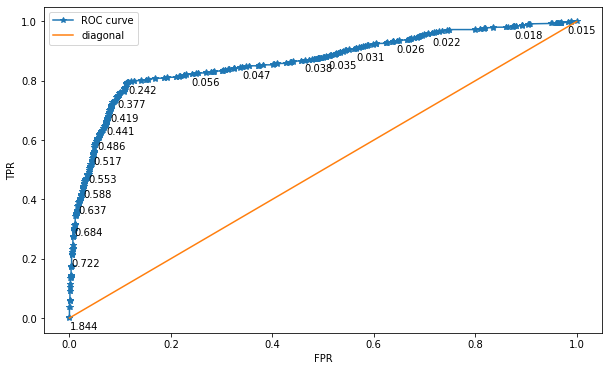

In [0]:
probs = best_model.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)

roc_auc = metrics.auc(fpr, tpr)

# plt.title('Receiver Operating Characteristic Curve')
# plt.plot(fpr, tpr, 'b', label = 'ROC AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')

# plt.show()

plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, '*-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
jump = 30
for x, y, txt in zip(fpr[::jump], tpr[::jump], thresholds[::jump]):
    plt.annotate(np.round(txt,3), (x, y-0.04))
# rnd_idx = 100
# plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'.format(np.round(thresholds[rnd_idx], 2)), 
#              xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
#              arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'),)
plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

plt.show()

In [0]:
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.242098, G-Mean=0.840


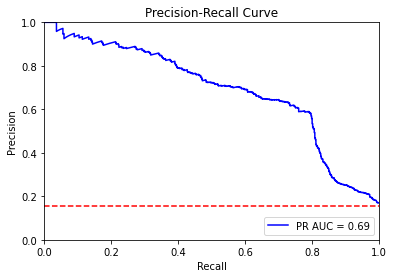

In [0]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, preds)

pr_auc = metrics.auc(recall, precision)

plt.title('Precision-Recall Curve')
plt.plot(recall, precision, 'b', label = 'PR AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0.155, 0.155],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()